from https://keras.io/examples/generative/vae/

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from progressbar import progressbar as pbar
import matplotlib.pyplot as plt
from rlxutils import subplots
from ppdl.models import transfer_weights
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

2022-01-17 18:47:12.059791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-17 18:47:12.059835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

2022-01-17 18:47:16.273466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-17 18:47:16.273505: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-17 18:47:16.273533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rlxyoga): /proc/driver/nvidia/version does not exist


In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255


# AE and VAE implementations sharing the same architecture

VAE has an extra layer to predict latent distribution std

In [5]:
tf.keras.backend.random_normal(shape=(3, 2))

2022-01-17 18:47:17.489938: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.50825334,  0.04180132],
       [ 0.1010862 ,  0.8438553 ],
       [ 0.41337126, -0.02644788]], dtype=float32)>

In [6]:
class Encoder(keras.Model):
    
    def __init__(self, latent_dim=2):
        super().__init__()
        self.conv1_layer = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="enc_conv1")
        self.conv2_layer = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="enc_conv2")
        self.dense_layer = layers.Dense(16, activation="relu", name="enc_dense1")

        self.output_layer = layers.Dense(latent_dim, name="enc_output")

    def call_stage(self, x):
        x = self.conv1_layer(x)
        x = self.conv2_layer(x)
        x = layers.Flatten()(x)
        x = self.dense_layer(x)
        return x
    
    def call(self, x):
        x = self.call_stage(x)
        x = self.output_layer(x)
        return x

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, no_sampling=False, **kwargs):
        super().__init__(**kwargs)
        self.no_sampling = no_sampling

    def disable_sampling(self):
        self.no_sampling = True

    def enable_sampling(self):
        self.no_sampling = False

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        if self.no_sampling:
            return z_mean
        else:
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
class VAE_Encoder(Encoder):
    
    def __init__(self, latent_dim=2):
        super().__init__(latent_dim=latent_dim)
        
        self.z_mean_layer    = self.output_layer
        self.z_log_var_layer = layers.Dense(latent_dim, name="enc_z_log_var")
        self.z_sampling_layer = Sampling(name="enc_sampling")

    def call(self, x):
        x = self.call_stage(x)
        z_mean    = self.z_mean_layer(x)
        z_log_var = self.z_log_var_layer(x)
        z_sample  = self.z_sampling_layer([z_mean, z_log_var])
        
        return [z_mean, z_log_var, z_sample]
    
class Decoder(keras.Model):
    
    def __init__(self, latent_dim=2):
        super().__init__()
        self.dense_layer = layers.Dense(7 * 7 * 64, activation="relu", name="dec_dense")
        self.convt1_layer = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", name="dec_convt1")
        self.convt2_layer = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="dec_convt2")
        self.convt_output_layer = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name="dec_convt_output")
        
    def call(self, x):
        x = self.dense_layer(x)
        x = layers.Reshape((7, 7, 64))(x)
        x = self.convt1_layer(x)
        x = self.convt2_layer(x)
        x = self.convt_output_layer(x)
        return x

In [7]:
class VAE(keras.Model):
    def __init__(self, latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = VAE_Encoder(latent_dim=latent_dim)
        self.decoder = Decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        return self.decoder(z)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

class VAE_no_sampling(VAE):
    """
    this does no sampling during training, it simply uses the mean obtain from the encoder
    """
    def train_step(self, data):
        self.encoder.z_sampling_layer.disable_sampling()
        r = super().train_step(data)
        self.encoder.z_sampling_layer.enable_sampling()
        return r

observe that, in general, KL divergence between two gaussians (see https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians):

$$K(d_1, d_2) = \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2} { \sigma_2^2 } - \frac{1}{2}$$

and in our VAE $d_2 = \mathcal{N}(0,1)$ and $d_1=\mathcal{N}(z_m, z_s)$ (the latent space)

In [8]:
class AE(keras.Model):
    def __init__(self, latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder()
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.reconstruction_loss_history = []

    def call(self, x):
        return self.decoder(self.encoder(x))
        
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
        grads = tape.gradient(reconstruction_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.reconstruction_loss_history.append(self.reconstruction_loss_tracker.result())
        return {
            "loss": self.reconstruction_loss_tracker.result()
        }

## train both VAE and AE

In [9]:
from collections import defaultdict

In [10]:
class LogHistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        self.history = defaultdict(lambda: [])
        
    def on_train_batch_end(self, batch, logs=None):
        for k,v in logs.items():
            self.history[k].append(v)        

In [11]:
latent_dim = 2

In [12]:
ae = AE(latent_dim=latent_dim)
ae_history = LogHistoryCallback()
ae.compile(optimizer=keras.optimizers.Adam())
ae.fit(mnist_digits, epochs=10, batch_size=128, callbacks=[ae_history])

Epoch 1/10
547/547 [==============================] - 29s 51ms/step - loss: 247.0607
Epoch 2/10
547/547 [==============================] - 28s 50ms/step - loss: 164.5102
Epoch 3/10
547/547 [==============================] - 27s 49ms/step - loss: 157.4806
Epoch 4/10
547/547 [==============================] - 27s 49ms/step - loss: 153.7700
Epoch 5/10
547/547 [==============================] - 26s 47ms/step - loss: 150.9073
Epoch 6/10
547/547 [==============================] - 27s 49ms/step - loss: 149.2074
Epoch 7/10
547/547 [==============================] - 27s 50ms/step - loss: 147.2194
Epoch 8/10
547/547 [==============================] - 27s 50ms/step - loss: 146.4270
Epoch 9/10
547/547 [==============================] - 27s 49ms/step - loss: 145.3725
Epoch 10/10
547/547 [==============================] - 27s 49ms/step - loss: 144.4022


In [13]:
vae = VAE(latent_dim = latent_dim)
vae_history = LogHistoryCallback()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128, callbacks=[vae_history])

Epoch 1/10
547/547 [==============================] - 28s 50ms/step - loss: 251.3182 - reconstruction_loss: 207.8073 - kl_loss: 3.3537
Epoch 2/10
547/547 [==============================] - 27s 50ms/step - loss: 189.7231 - reconstruction_loss: 184.4738 - kl_loss: 3.4414
Epoch 3/10
547/547 [==============================] - 27s 50ms/step - loss: 182.3991 - reconstruction_loss: 173.9269 - kl_loss: 4.3441
Epoch 4/10
547/547 [==============================] - 26s 47ms/step - loss: 167.2452 - reconstruction_loss: 159.8160 - kl_loss: 5.7697
Epoch 5/10
547/547 [==============================] - 26s 47ms/step - loss: 161.9323 - reconstruction_loss: 155.3109 - kl_loss: 6.0661
Epoch 6/10
547/547 [==============================] - 26s 47ms/step - loss: 159.7428 - reconstruction_loss: 153.1060 - kl_loss: 6.2183
Epoch 7/10
547/547 [==============================] - 26s 47ms/step - loss: 158.2384 - reconstruction_loss: 151.7047 - kl_loss: 6.2869
Epoch 8/10
547/547 [==============================] - 2

In [14]:
# VAE with no sampling during training --- seems to minimize faster both reconstruction and KL loss (overfits!!!)
nvae = VAE_no_sampling(latent_dim = latent_dim)
nvae_history = LogHistoryCallback()
nvae.compile(optimizer=keras.optimizers.Adam())
nvae.fit(mnist_digits, epochs=10, batch_size=128, callbacks=[nvae_history])

Epoch 1/10
547/547 [==============================] - 27s 47ms/step - loss: 242.8557 - reconstruction_loss: 189.1256 - kl_loss: 1.3945
Epoch 2/10
547/547 [==============================] - 26s 47ms/step - loss: 161.8632 - reconstruction_loss: 159.6056 - kl_loss: 0.4639
Epoch 3/10
547/547 [==============================] - 27s 49ms/step - loss: 155.5494 - reconstruction_loss: 154.0499 - kl_loss: 0.4691
Epoch 4/10
547/547 [==============================] - 27s 49ms/step - loss: 151.6743 - reconstruction_loss: 150.7937 - kl_loss: 0.4805
Epoch 5/10
547/547 [==============================] - 27s 50ms/step - loss: 150.0547 - reconstruction_loss: 148.9751 - kl_loss: 0.4693
Epoch 6/10
547/547 [==============================] - 27s 50ms/step - loss: 148.3027 - reconstruction_loss: 147.6532 - kl_loss: 0.4587
Epoch 7/10
547/547 [==============================] - 27s 49ms/step - loss: 147.1872 - reconstruction_loss: 146.6032 - kl_loss: 0.4516
Epoch 8/10
547/547 [==============================] - 2

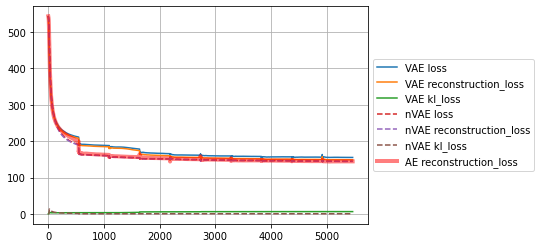

In [15]:
for k,v in vae_history.history.items():
    plt.plot(v, label=f"VAE {k}")

for k,v in nvae_history.history.items():
    plt.plot(v, label=f"nVAE {k}", ls="--")


plt.plot(ae_history.history['loss'], label="AE reconstruction_loss", color="red", lw=4, alpha=.5)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid();

## Encoder distributions over the full dataset

one chart per `latent_dim`

observe how AE **tends** to VAE

In [16]:
vaezm,vaezs,vaez = [i.numpy() for i in vae.encoder(mnist_digits)]
nvaezm,nvaezs,nvaez = [i.numpy() for i in nvae.encoder(mnist_digits)]
aez = ae.encoder(mnist_digits).numpy()

2022-01-17 19:00:58.768609: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1756160000 exceeds 10% of free system memory.
2022-01-17 19:00:58.999214: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1756160000 exceeds 10% of free system memory.
2022-01-17 19:00:59.252368: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1756160000 exceeds 10% of free system memory.
2022-01-17 19:01:00.362196: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1756160000 exceeds 10% of free system memory.
2022-01-17 19:01:00.662340: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1756160000 exceeds 10% of free system memory.


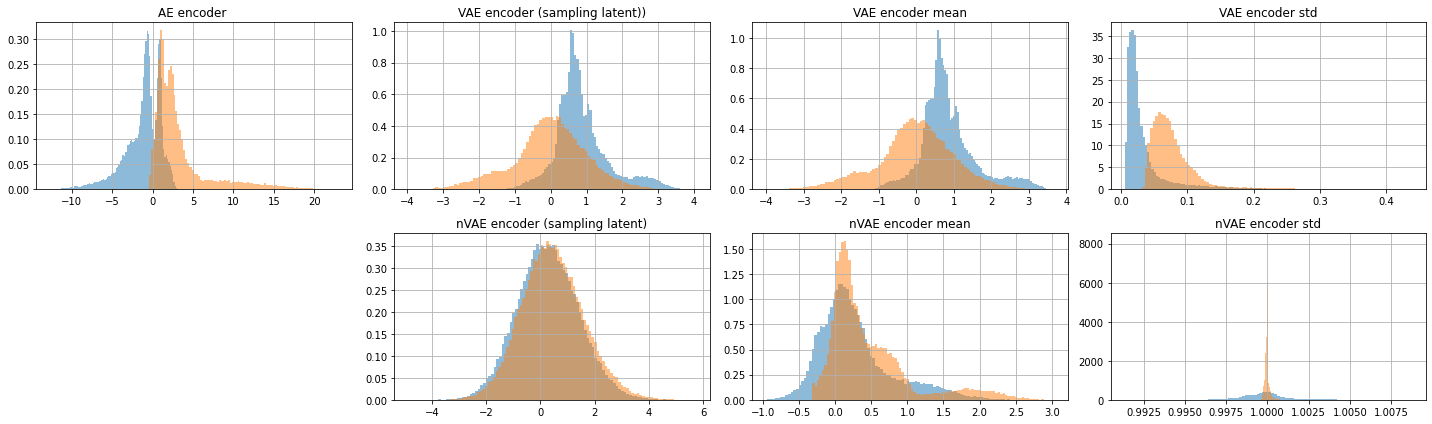

In [24]:
for ax,k in subplots(8, usizex=5, n_cols=4):
    if k==0:
        for i in range(latent_dim):
            plt.hist(aez[:,i], density=True, bins=100, alpha=.5);
        plt.title("AE encoder ")
        plt.grid();
    if k==1:
        for i in range(latent_dim):
            plt.hist(vaez[:,i], density=True, bins=100, alpha=.5);
        plt.title("VAE encoder (sampling latent))")
        plt.grid();
    if k==2:
        for i in range(latent_dim):
            plt.hist(vaezm[:,i], density=True, bins=100, alpha=.5);
        plt.title("VAE encoder mean")
        plt.grid();
    if k==3:
        for i in range(latent_dim):
            plt.hist(np.exp(.5*vaezs[:,i]), density=True, bins=100, alpha=.5);
        plt.title("VAE encoder std")
        plt.grid();
    if k==4:
        plt.axis("off")
    if k==5:
        for i in range(latent_dim):
            plt.hist(nvaez[:,i], density=True, bins=100, alpha=.5);
        plt.title("nVAE encoder (sampling latent)")
        plt.grid();
    if k==6:
        for i in range(latent_dim):
            plt.hist(nvaezm[:,i], density=True, bins=100, alpha=.5);
        plt.title("nVAE encoder mean")
        plt.grid();
    if k==7:
        for i in range(latent_dim):
            plt.hist(np.exp(.5*nvaezs[:,i]), density=True, bins=100, alpha=.5);
        plt.title("nVAE encoder std")
        plt.grid();

plt.tight_layout()

## Output for a selected input image

- VAE and nVAE outputs a distribution of images (a distribution per pixel)
- AE outputs a single image (a value per pixel)
- nVAE has converged faster to the desired latent distribuition N(0,I)


In [18]:
# select one random input
idx = np.random.randint(len(mnist_digits))

In [19]:
# AE is deterministic, so we do inference just once and obtain one value for each output pixel
output_ae = ae(mnist_digits[idx:idx+1]).numpy()
output_ae.shape

(1, 28, 28, 1)

In [20]:
# VAE is stochastic, so we do inference many times to understand the output distribution of each pixel
output_vae = vae(np.repeat(mnist_digits[idx:idx+1],10000, axis=0)).numpy()
output_vae.shape

(10000, 28, 28, 1)

In [21]:
# nVAE is stochastic, so we do inference many times to understand the output distribution of each pixel
output_nvae = nvae(np.repeat(mnist_digits[idx:idx+1],10000, axis=0)).numpy()
output_nvae.shape

(10000, 28, 28, 1)

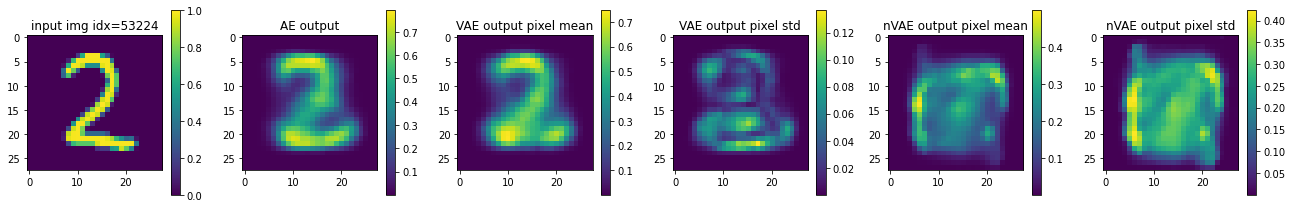

In [22]:
for ax, i in subplots(6):
    if i==0:
        plt.imshow(mnist_digits[idx][:,:,0])
        plt.title(f"input img idx={idx}")
        plt.colorbar();
    if i==1:
        plt.imshow(output_ae[0,:,:,0])
        plt.title("AE output")
        plt.colorbar();        
    if i==2:
        plt.imshow(output_vae[:,:,:,0].mean(axis=0))
        plt.title("VAE output pixel mean")
        plt.colorbar();        
    if i==3:
        plt.imshow(output_vae[:,:,:,0].std(axis=0))
        plt.title("VAE output pixel std")
        plt.colorbar();
    if i==4:
        plt.imshow(output_nvae[:,:,:,0].mean(axis=0))
        plt.title("nVAE output pixel mean")
        plt.colorbar();        
    if i==5:
        plt.imshow(output_nvae[:,:,:,0].std(axis=0))
        plt.title("nVAE output pixel std")
        plt.colorbar();
plt.tight_layout()


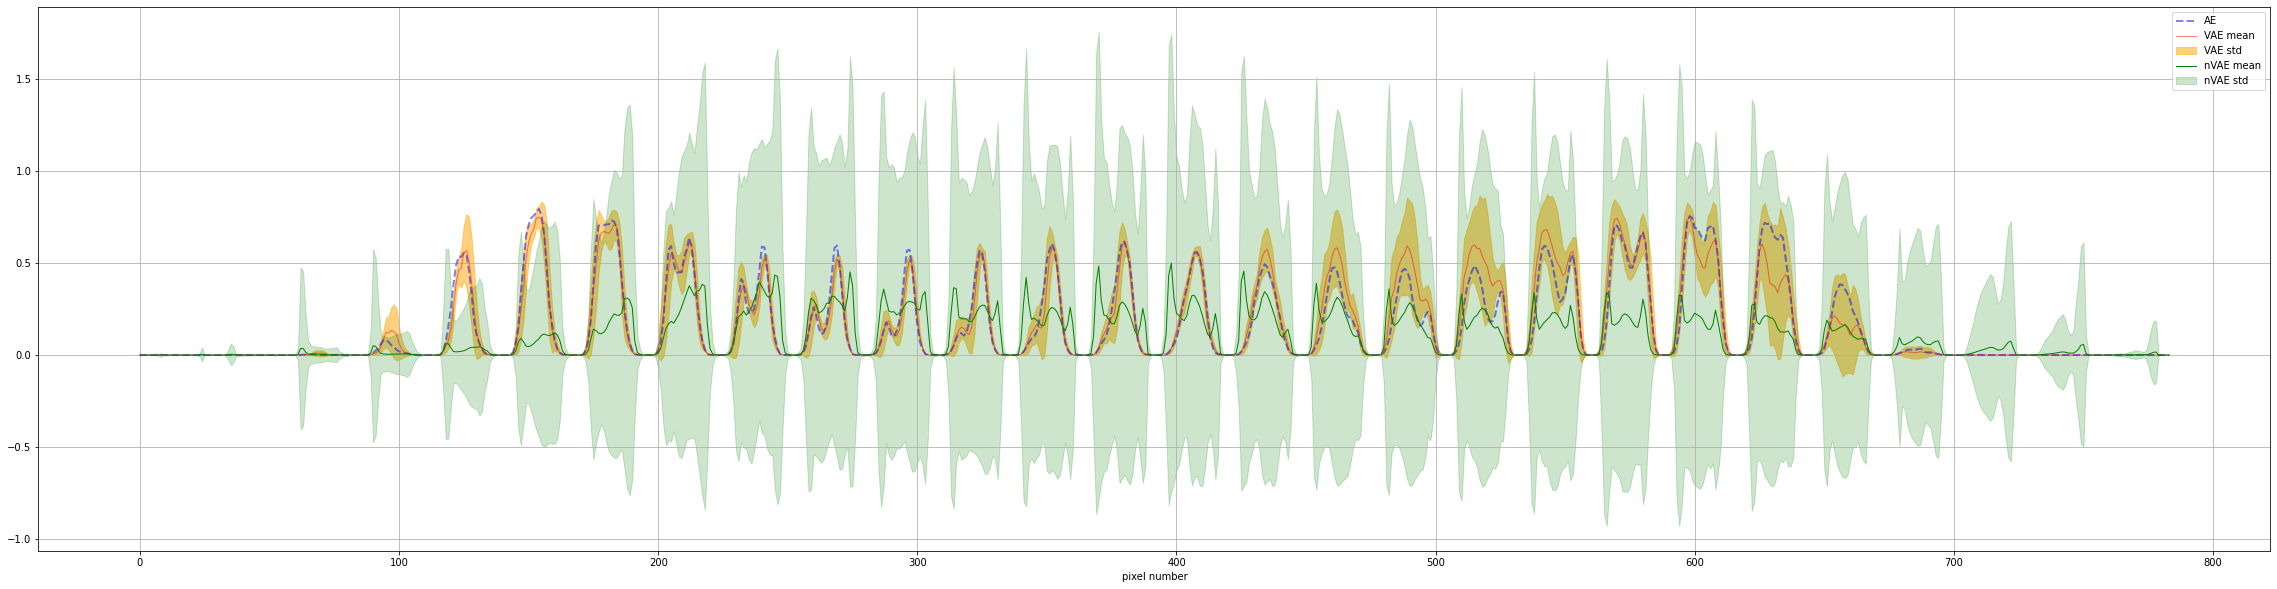

In [23]:
plt.figure(figsize=(40,10))
plt.plot(output_ae.reshape(-1), color="blue", alpha=.5, lw=2, ls="--", label="AE")

om = output_vae.mean(axis=0).reshape(-1)
os = output_vae.std(axis=0).reshape(-1)
nom = output_nvae.mean(axis=0).reshape(-1)
nos = output_nvae.std(axis=0).reshape(-1)

plt.plot(om, color="red", alpha=.5, lw=1, label="VAE mean")
plt.fill_between(range(len(om)), om-3*os, om+3*os, color="orange", alpha=.5, label="VAE std")

plt.plot(nom, color="green", alpha=1, lw=1, label="nVAE mean")
plt.fill_between(range(len(nom)), nom-3*nos, nom+3*nos, color="green", alpha=.2, label="nVAE std")


plt.xlabel("pixel number")
plt.legend();
plt.grid();

show VAE distribution of pixel with largest mean and largest std

In [ ]:
my,mx = output_vae.mean(axis=0).argmax()//28, output_vae.mean(axis=0).argmax()%28
sy,sx = output_vae.std(axis=0).argmax()//28, output_vae.std(axis=0).argmax()%28
ry1,rx1,ry2,rx2 = np.random.randint(28, size=4)

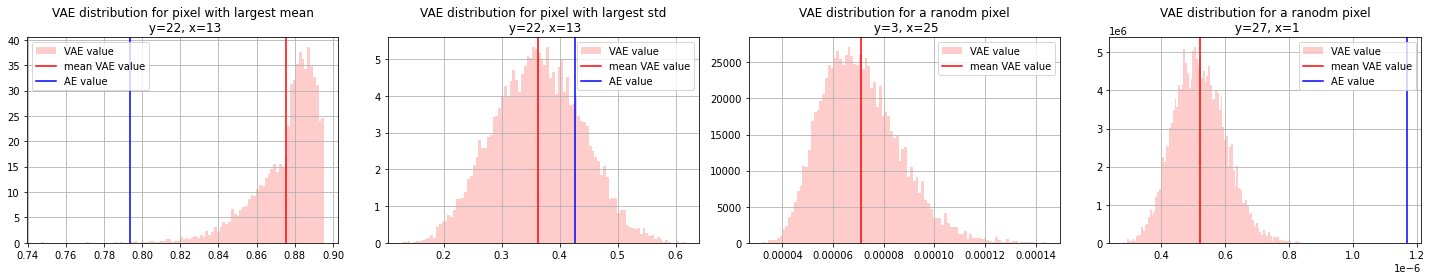

In [ ]:
vmin, vmax = output_vae.min(), np.max([output_ae.max(),1])+.1
vmin -= .1
for ax,i in subplots(4, usizex=5, usizey=4):
    if i==0:
        plt.hist(output_vae[:,my,mx,0], density=True, color="red", bins=100, alpha=.2, label="VAE value");
        plt.axvline(output_vae[:,my,mx,0].mean(), color="red", label="mean VAE value")
        plt.axvline(output_ae[0,my,mx,0], color="blue", label="AE value")
        plt.grid(); plt.legend();
        plt.title(f"VAE distribution for pixel with largest mean\n y={my}, x={mx}")
        #plt.xlim(vmin, vmax)
    if i==1:
        plt.hist(output_vae[:,sy,sx,0], density=True, color="red", bins=100, alpha=.2, label="VAE value");
        plt.axvline(output_vae[:,sy,sx,0].mean(), color="red", label="mean VAE value")
        plt.axvline(output_ae[0,sy,sx,0], color="blue", label="AE value")
        plt.grid(); plt.legend();
        plt.title(f"VAE distribution for pixel with largest std\n y={my}, x={mx}")
        #plt.xlim(vmin, vmax)
    if i==2:
        plt.hist(output_vae[:,ry1,rx1,0], density=True, color="red", bins=100, alpha=.2, label="VAE value");
        plt.axvline(output_vae[:,ry1,rx1,0].mean(), color="red", label="mean VAE value")
        plt.grid(); plt.legend();
        plt.title(f"VAE distribution for a ranodm pixel\n y={ry1}, x={rx1}")
    if i==3:
        plt.hist(output_vae[:,ry2,rx2,0], density=True, color="red", bins=100, alpha=.2, label="VAE value");
        plt.axvline(output_vae[:,ry2,rx2,0].mean(), color="red", label="mean VAE value")
        plt.title(f"VAE distribution for a ranodm pixel\n y={ry2}, x={rx2}")
        plt.axvline(output_ae[0,ry2,rx2,0], color="blue", label="AE value")
        plt.grid(); plt.legend();
plt.tight_layout()

## Shared weights for VAE and AE

transfer weights from VAE to AE (except VEA weights to estimate std `z_log_var`)

AE output is **equivalent** to VAE-mean output on the same input image 

In [25]:
transfer_weights(from_model = vae.encoder, to_model = ae.encoder)

layers transferred     ['enc_conv1', 'enc_conv2', 'enc_dense1', 'enc_output']
layers not transferred ['enc_z_log_var', 'enc_sampling']


In [26]:
transfer_weights(from_model = vae.decoder, to_model = ae.decoder)

layers transferred     ['dec_dense', 'dec_convt1', 'dec_convt2', 'dec_convt_output']
layers not transferred []


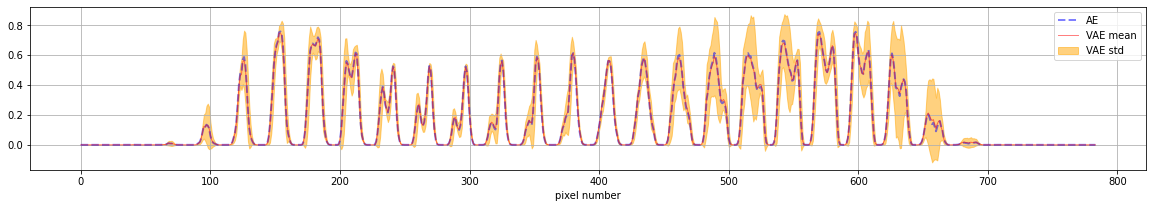

In [27]:
output_ae = ae(mnist_digits[idx:idx+1]).numpy()
output_vae = vae(np.repeat(mnist_digits[idx:idx+1],10000, axis=0)).numpy()

plt.figure(figsize=(20,3))
plt.plot(output_ae.reshape(-1), color="blue", alpha=.5, lw=2, ls="--", label="AE")

om = output_vae.mean(axis=0).reshape(-1)
os = output_vae.std(axis=0).reshape(-1)
plt.plot(om, color="red", alpha=.5, lw=1, label="VAE mean")
plt.fill_between(range(len(om)), om-3*os, om+3*os, color="orange", alpha=.5, label="VAE std")
plt.xlabel("pixel number")
plt.legend();
plt.grid();

## Fix input and compute gradients

procedure:

- select a random image
- compute gradients with AE (deterministic, just once)
- compute gradients with VAE (stochastic, do it many times) 
- for each differentiable parameter, mean VAE gradient corresponds to the AE gradient

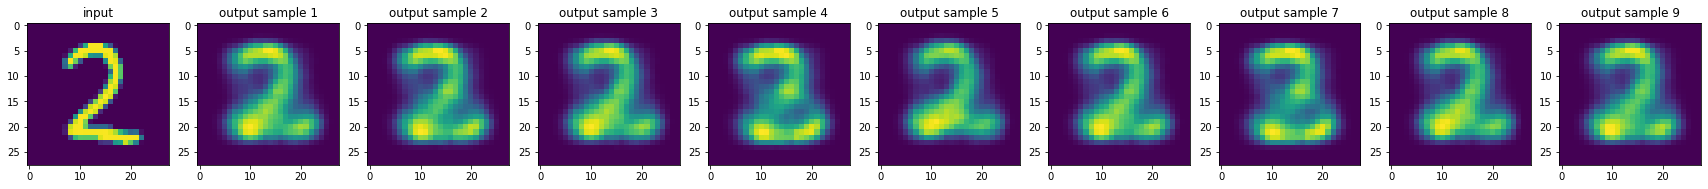

In [28]:
img_input = mnist_digits[idx:idx+1]
img_output = vae(img_input)

for ax,i in subplots(10):
    if i == 0:
        plt.imshow(img_input[0])
        plt.title("input")
    if i > 0:
        plt.imshow(vae(img_input)[0])
        plt.title(f"output sample {i}")


In [29]:
get_wname = lambda x: "/".join(x.name.split("/")[-2:])

def compute_reconstruction_gradient(model, img_input, weights=None):

    if weights is None:
        weights = model.trainable_weights
    
    with tf.GradientTape() as tape:
        img_output = model(img_input)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(img_input, img_output), axis=(1, 2)
            )
        )
    grads = tape.gradient(reconstruction_loss, weights)
    r = {get_wname(w): g.numpy() for g,w in zip(grads, weights)}
    r['loss'] = reconstruction_loss.numpy()
    return r

In [30]:
w_ae = [get_wname(i) for i in ae.trainable_weights]
w_vae = [get_wname(i) for i in vae.trainable_weights]
w_names = list(set(w_ae).intersection(w_vae))

In [31]:
vae_grads = [compute_reconstruction_gradient(vae, img_input) for _ in pbar(range(10000))]
ae_grads  =  compute_reconstruction_gradient(ae, img_input)

100% (10000 of 10000) |##################| Elapsed Time: 0:02:45 Time:  0:02:45


In [32]:
def plotw(w_name):
    vgm = np.r_[[i[w_name] for i in vae_grads]].mean(axis=0).reshape(-1)
    vgs = np.r_[[i[w_name] for i in vae_grads]].std(axis=0).reshape(-1) 
    plt.figure(figsize=(20,3))
    
    plt.plot(vgm, color="red", alpha=.5, label="VAE mean")
    plt.fill_between(range(len(vgm)), vgm-3*vgs, vgm+3*vgs, color="orange", alpha=.5, label="VAE std")
    
    plt.plot(ae_grads[w_name].reshape(-1), color="blue", alpha=.5, label="AE")
    
    plt.title(f"parameter {w_name}")
    plt.xlabel("parameter component number")
    plt.grid();
    plt.legend();

### the mean gradient of VAE converges to the gradient of AE

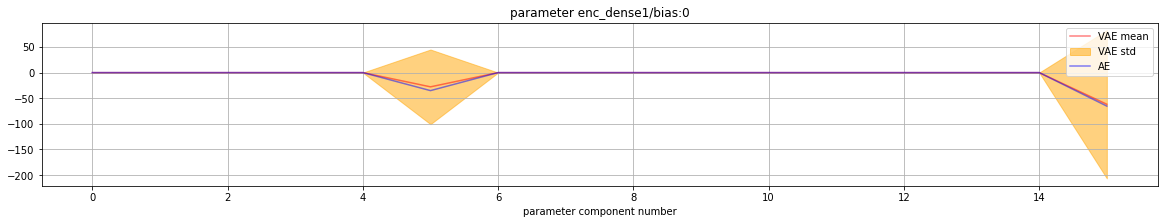

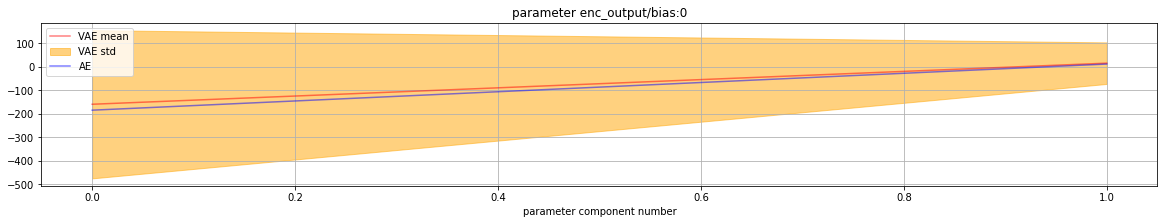

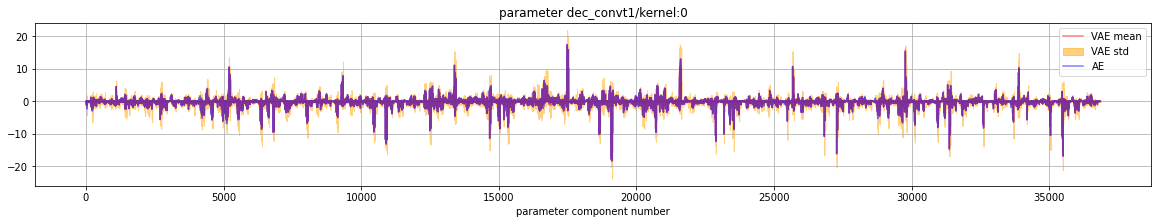

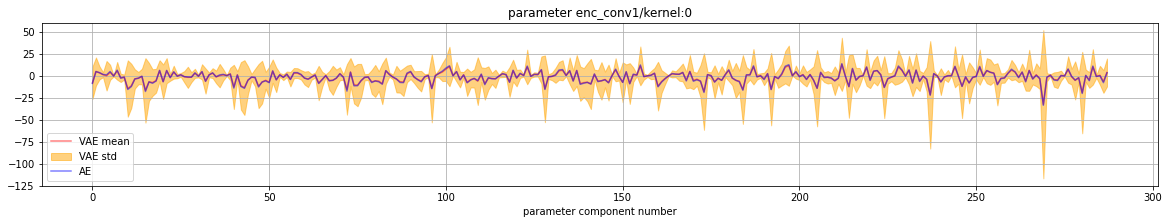

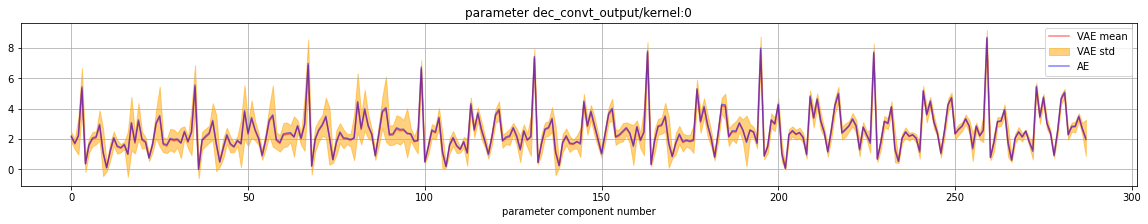

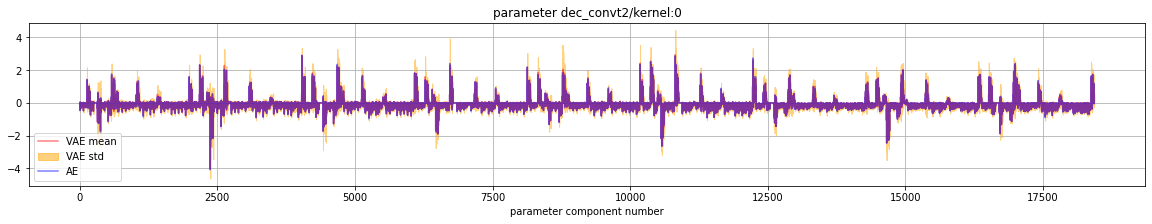

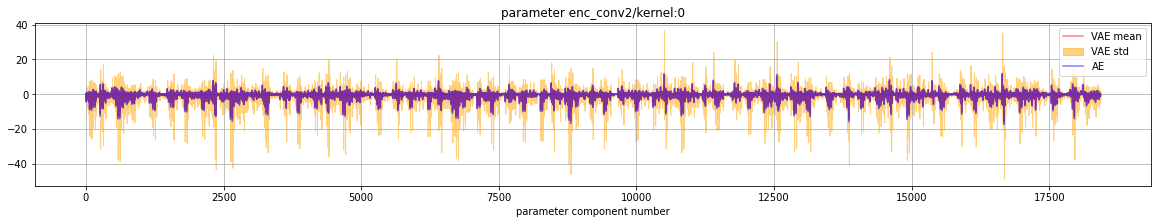

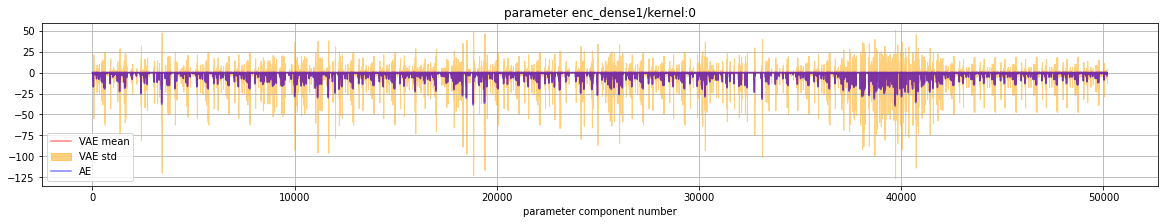

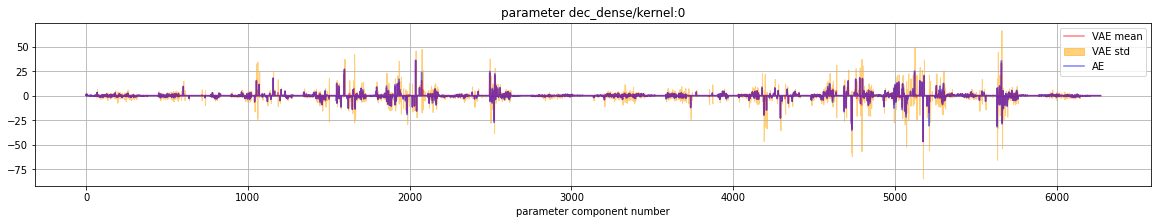

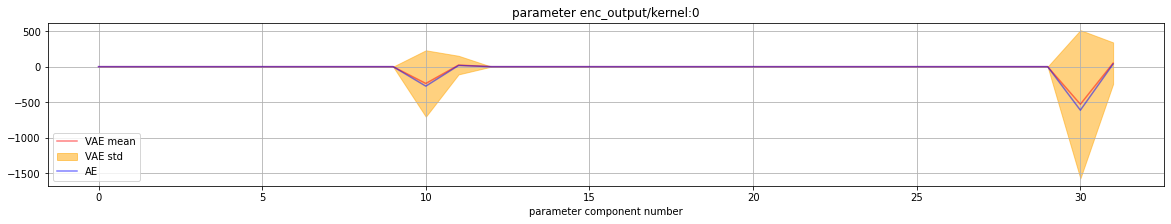

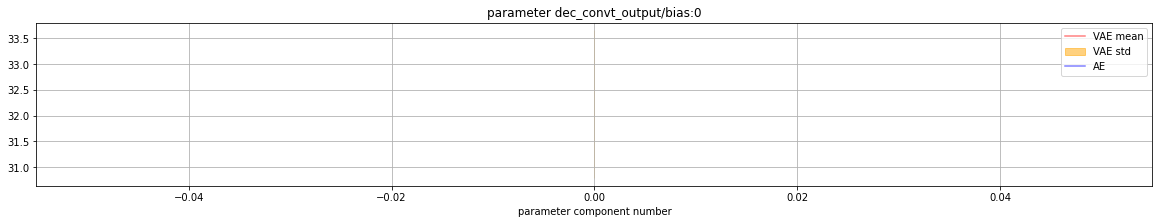

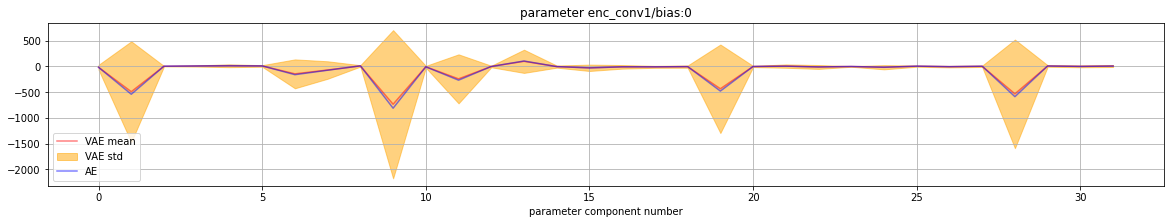

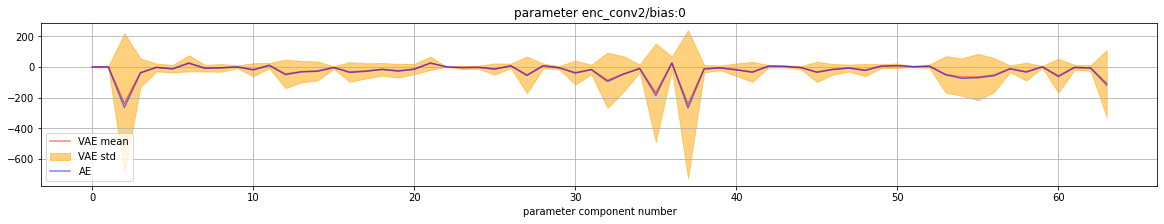

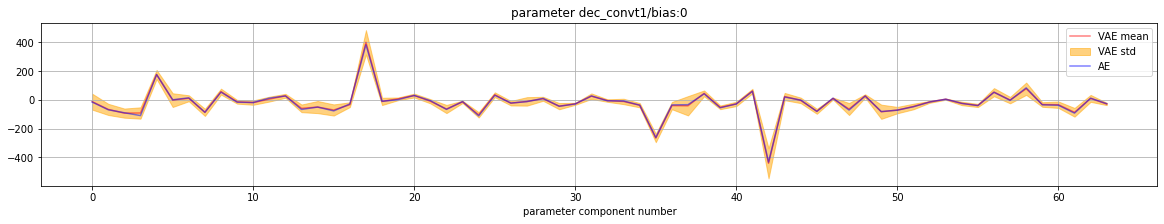

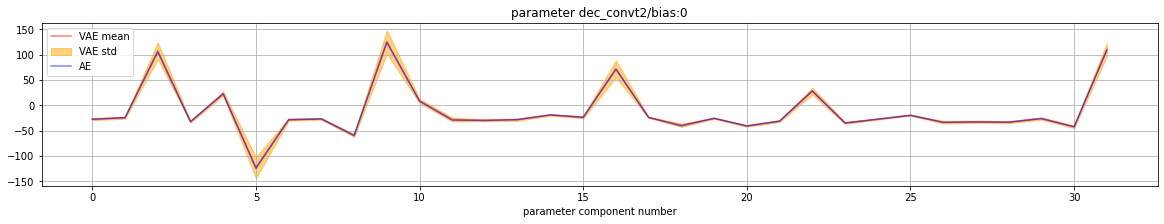

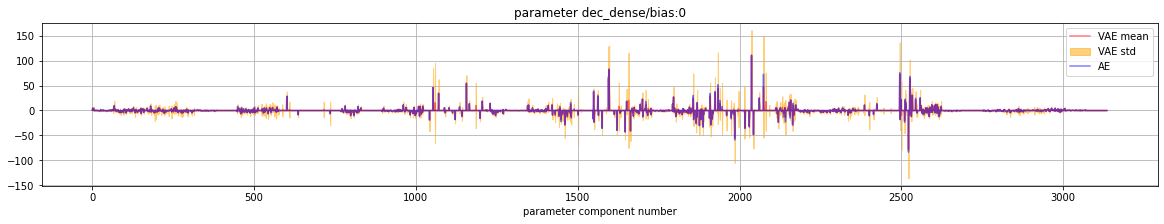

In [33]:
for w_name in w_names:
    plotw(w_name)

### the mean recostruction loss of VAE seems harder to converge to AE loss

additionally recall that:

- VAE loss has two terms: reconstruction and KL-divergence, while AE only uses the reconstruction loss
- thus, we are only comparing the reconstruction loss
- there is high variability on the loss, only with a large sample we can see that it converges

Text(0.5, 0, 'loss values')

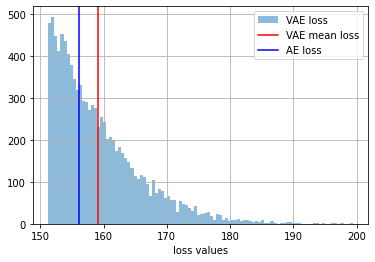

In [35]:
vloss = np.r_[[i['loss'] for i in vae_grads]]
plt.hist(vloss, bins=100, alpha=.5, label="VAE loss");
plt.axvline(vloss.mean(), color="red", label="VAE mean loss")
plt.axvline(ae_grads['loss'], color="blue", label="AE loss")
plt.grid(); plt.legend();
plt.xlabel("loss values")